In [1]:
import os
import sys
import cortex
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import scipy.stats.mstats as mstats
import copy
import yaml
import joblib

from nilearn import plotting
from scipy.ndimage import binary_dilation
from PIL import Image
from importlib import reload
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator, NullFormatter
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm import tqdm
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from typing import Dict, Tuple, Union
from scipy.special import softmax
from scipy.stats import zscore as zs

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from unet_recon.inpainting import UNet
from funcs.analyses import univariate_regression

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy']


In [2]:
def reload_nsp():
    import funcs.natspatpred
    importlib.reload(funcs.natspatpred)
    from funcs.natspatpred import NatSpatPred, VoxelSieve
    NSP = NatSpatPred()
    NSP.initialise()
    return NSP

import lgnpy.CEandSC.lgn_statistics
# from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN
import importlib
from importlib import reload
import funcs.natspatpred
import unet_recon.inpainting

importlib.reload(funcs.natspatpred)
importlib.reload(unet_recon.inpainting)
importlib.reload(lgnpy.CEandSC.lgn_statistics)

from unet_recon.inpainting import UNet
from funcs.natspatpred import NatSpatPred, VoxelSieve
from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN

soepstengesl
soepstengesl


In [3]:
NSP = NatSpatPred()
NSP.initialise()

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [4]:

print(cortex.options.config['basic']['filestore'])
pc_files = '/home/rfpred/envs/rfenv/share/pycortex/db'

# Reload the subjects and check whether they've successfully been reloaded in the pycortex database
cortex.db.reload_subjects()
print(cortex.db.subjects.keys())

# Manually set the subjects directory to the specific FreeSurfer directory
os.environ['SUBJECTS_DIR'] = f"{NSP.nsd_datapath}/nsddata/freesurfer/"
print(os.environ['SUBJECTS_DIR'])

/home/rfpred/envs/rfenv/share/pycortex/db
dict_keys(['S1', 'subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08'])
/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/


In [17]:
# cortex.db.save_mri('reference_aligned.nii.gz','subj01','reference')



AttributeError: 

In [ ]:

fs_path = f'{NSP.nsd_datapath}/nsddata/freesurfer/{subject}/surf'

# Load left hemisphere surfaces
lh_white_vertices, lh_white_triangles = nib.freesurfer.io.read_geometry(f'{fs_path}/lh.white')
lh_pial_vertices, lh_pial_triangles = nib.freesurfer.io.read_geometry(f'{fs_path}/lh.pial')

# Similarly load right hemisphere surfaces
rh_white_vertices, rh_white_triangles = nib.freesurfer.io.read_geometry(f'{fs_path}/rh.white')
rh_pial_vertices, rh_pial_triangles = nib.freesurfer.io.read_geometry(f'{fs_path}/rh.pial')

In [7]:
# Import the FreeSurfer subject
cortex.freesurfer.import_subj(
    "subj02", freesurfer_subject_dir=f"{NSP.nsd_datapath}/nsddata/freesurfer/",
    whitematter_surf="white"
)

b'created by emilya on Sun Jun 23 00:50:37 2019\n'
b'created by emilya on Sun Jun 23 05:13:36 2019\n'
b'created by emilya on Sun Jun 23 00:50:51 2019\n'
b'created by emilya on Sun Jun 23 05:36:01 2019\n'


In [9]:
# This might work later. I just need to copy, or sync rather, the fsaverage directory to my own folders. 

import os
import mne


label = mne.read_label(os.path.join(os.environ['SUBJECTS_DIR'], 'fsaverage', 'label', 'lh.wang2015atlas.V1v.label'))
m = np.zeros(cortex.db.fsaverage.surfaces.inflated.get()[0][0].shape[0])
m[label.vertices] = 1
V = cortex.dataset.Vertex(m, 'fsaverage')
# cortex.webshow(V)
cortex.quickview(V)
# /home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/subj01/label/lh.prfeccentricity.mgz

FileNotFoundError: [Errno 2] No such file or directory: '/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/fsaverage/label/lh.wang2015atlas.V1v.label'

OSError: 

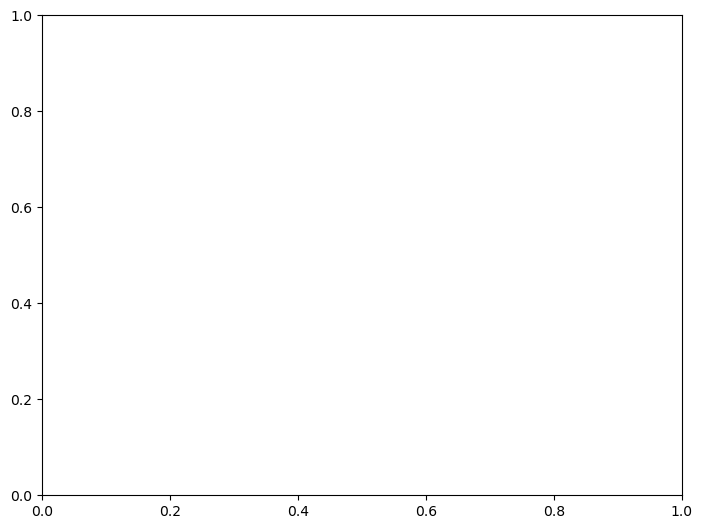

In [10]:
import cortex

# Get the inflated surface information
inflated_surface = cortex.db.get_surfinfo('subj01', 'curvature')

# Create a 3D visualization of the surface data
# Replace 'data' with your surface data
cortex.quickshow(inflated_surface)

# Show the visualization
plt.show()

RuntimeError: Inkscape doesn't seem to be installed on this system.SVGOverlay.get_texture requires inkscape.Please make sure that inkscape is installed and that is accessible from the terminal.

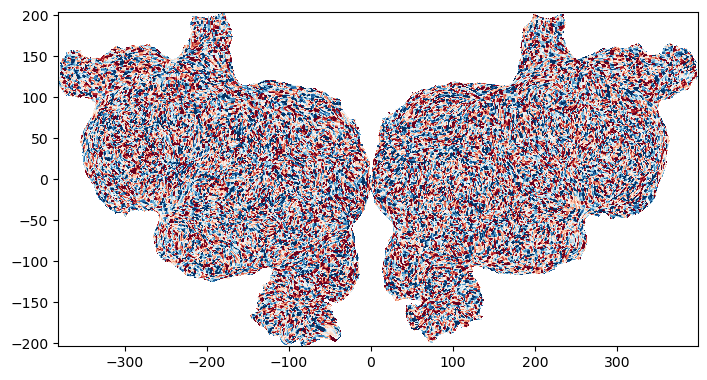

In [8]:
import cortex
import numpy as np

# Create a random volume
volume = cortex.Volume.random('S1', 'fullhead', vmin=-1, vmax=1)

# Display the volume on an inflated surface
cortex.quickshow(volume, with_curvature=True, surfaces=["inflated"])
# cortex.webgl.show()

In [ ]:

# from nilearn import plotting
file_path = "/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/subj01/label/lh.prfeccentricity.mgz"
import nibabel as nib
import matplotlib.pyplot as plt

# Load the .mgz file
img = nib.load(file_path)

# Get the data from the image
data = img.get_fdata()

# Create a new figure
fig = plt.figure()

# Plot the data
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')

# Save the figure as an image file
# fig.savefig('output.png')

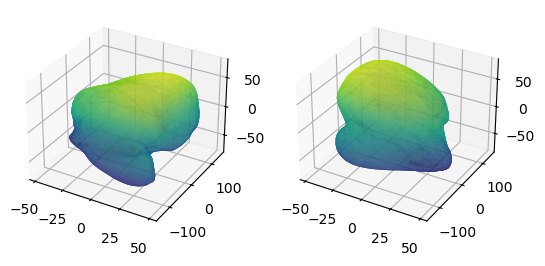

In [9]:
# Get the vertices and faces for each hemisphere
vertices_left, faces_left = cortex.db.get_surf('subj01', 'inflated', 'lh')
vertices_right, faces_right = cortex.db.get_surf('subj01', 'inflated', 'rh')

# Plot the cortical surface for each hemisphere
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
ax[0].plot_trisurf(vertices_left[:, 0], vertices_left[:, 1], faces_left, vertices_left[:, 2], cmap='viridis')
ax[1].plot_trisurf(vertices_right[:, 0], vertices_right[:, 1], faces_right, vertices_right[:, 2], cmap='viridis')
plt.show()

In [19]:
pc_files

'/home/rfpred/envs/rfenv/share/pycortex/db'

In [20]:
# This took 6m40 to run
s1_path = f'{pc_files}/subj01/'
cortex.align.automatic('subj01', 'test_transform', f'{s1_path}anatomicals/raw.nii.gz')

# cortex.align.automatic('subj01', 'test_transform', f'{s1_path}anatomicals/raw.nii.gz', use_fs_bbr=True)

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cortex/align.py:413: UserWarning: Defaults changed in pycortex 1.2.8. Now automatic alignment uses Freesurfer's bbregister and mri_coreg for initialization. If you want to use FSL's BBR, use the function `cortex.align.automatic_fsl` instead.
  warnings.warn(


Running freesurfer BBR
tmp /tmp/tmp7r7773mv/tmp.bbregister.1010183
Log file is /tmp/tmp7r7773mv/register.log
vr 24 mei 2024 15:34:01 CEST

setenv SUBJECTS_DIR /home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/
cd /home/rfpred
/usr/local/freesurfer/7.4.1/bin/bbregister --s subj01 --mov /home/rfpred/envs/rfenv/share/pycortex/db/subj01/anatomicals/raw.nii.gz --reg /tmp/tmp7r7773mv/register.dat --t2 --init-coreg

bbregister 7.4.1
Linux tux14psy 6.5.0-28-generic #29~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Apr  4 14:39:20 UTC 2 x86_64 x86_64 x86_64 GNU/Linux
FREESURFER_HOME /usr/local/freesurfer/7.4.1/
mri_convert /home/rfpred/envs/rfenv/share/pycortex/db/subj01/anatomicals/raw.nii.gz /tmp/tmp7r7773mv/tmp.bbregister.1010183/template.nii
mri_convert /home/rfpred/envs/rfenv/share/pycortex/db/subj01/anatomicals/raw.nii.gz /tmp/tmp7r7773mv/tmp.bbregister.1010183/template.nii 
reading from /home/rfpred/envs/rfenv/share/pycortex/db/subj01/anatomicals/raw.nii.gz...
TR=1000.00, TE=0.00, TI=

In [12]:
cortex.align.fs_manual('subj01', 'test_transform')

Wrote:
subj01
0.800000
0.800000
0.150000
9.999844580886430e-01 -1.869652564557680e-03 -5.273272827614439e-03 8.590496234874649e-01
1.868597608895564e-03 9.999982267617913e-01 -2.050120414050228e-04 -4.420423885857190e+00
5.273647219295012e-03 1.951553887897043e-04 9.999860674140759e-01 -4.751339342658042e+00
0.000000000000000e+00 0.000000000000000e+00 0.000000000000000e+00 1.000000000000000e+00
=== Calling (NO REFERENCE PROVIDED): ===
freeview -v $SUBJECTS_DIR/subj01/mri/orig.mgz /home/rfpred/envs/rfenv/share/pycortex/db/subj01/transforms/test_transform/reference.nii.gz:reg=/tmp/fsalign_b0q3tycy/register.dat -f $SUBJECTS_DIR/subj01/surf/lh.white:edgecolor=yellow $SUBJECTS_DIR/subj01/surf/rh.white:edgecolor=yellow $SUBJECTS_DIR/subj01/surf/lh.pial:edgecolor=blue $SUBJECTS_DIR/subj01/surf/rh.pial:edgecolor=blue

REGISTRATION MUST BE SAVED AS:

/tmp/fsalign_b0q3tycy/register.lta


could not connect to display 
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, webgl, xcb.

Aborted (core dumped)


OSError: Problem with FreeView!

In [ ]:

# Visualise the stuff

# Create a Vertex object for each hemisphere
lh_vertex = cortex.Vertex(lh_white_vertices, subject, cmap='hot', vmin=-2, vmax=2)
rh_vertex = cortex.Vertex(rh_white_vertices, subject, cmap='hot', vmin=-2, vmax=2)

# Display the vertices on a flatmap
cortex.quickshow((lh_vertex, rh_vertex))

In [ ]:
import cortex

# Get the vertices and faces for each hemisphere
vertices_left, _ = cortex.db.get_surf('subj01', 'lh')
vertices_right, _ = cortex.db.get_surf('subj01', 'rh')

# Get the number of vertices in each hemisphere
num_vertices_left = len(vertices_left)
num_vertices_right = len(vertices_right)

print(f"Number of vertices in left hemisphere: {num_vertices_left}")
print(f"Number of vertices in right hemisphere: {num_vertices_right}")

In [ ]:
# Load the .mgz file
trans_r = nib.load(f'{NSP.nsd_datapath}/nsddata/ppdata/subj01/transforms/rh.func1pt0-to-pial.mgz')
trans_l = nib.load(f'{NSP.nsd_datapath}/nsddata/ppdata/subj01/transforms/lh.func1pt0-to-pial.mgz')

data_r = trans_r.get_fdata()
data_l = trans_l.get_fdata()

In [ ]:
# This runs a terminal command to convert the nifti file to a .mgz file. I'm not sure how good it works
# as it doesn't use any of the transformations given in the NSD dataset files.
import subprocess

# Define the command
command = ['mri_convert', f'{own_fspath}/fs_test_enc.nii', f'{own_fspath}/enc_brain.mgz']

# Run the command
subprocess.run(command, check=True)


In [ ]:
# Print the shape of the volume
print(vol_r.data.shape)

# Print the first few values of the volume
print(vol_r.data[:10])

In [ ]:
# Load the .mgz file
trans_r = nib.load(f'{NSP.nsd_datapath}/nsddata/ppdata/subj01/transforms/rh.func1pt0-to-pial.mgz')
trans_l = nib.load(f'{NSP.nsd_datapath}/nsddata/ppdata/subj01/transforms/lh.func1pt0-to-pial.mgz')

# Get the data from the .mgz file
data_r = trans_r.get_fdata()
data_l = trans_l.get_fdata()



# # Change the order of the axes from xyz to zyx
# data_r = np.transpose(data_r, (2, 1, 0))
# data_l = np.transpose(data_l, (2, 1, 0))

# Create a pycortex Volume
vol_r = cortex.Volume(data_r, '/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/subj01', 'identity', vmin=None, vmax=None, cmap='hot')
vol_l = cortex.Volume(data_l, '/home/rfpred/data/natural-scenes-dataset/nsddata/freesurfer/subj01', 'identity', vmin=None, vmax=None, cmap='hot')

# Display the volume
cortex.webgl.show(vol_r)
cortex.webgl.show(vol_l)